<center>
    <h1><b>Thị giác máy tính</b></h1>
    <h2><b>Nhận diện ảnh và giải bài toán Sudoku</b></h2>
</center>

---
**Sinh viên thực hiện:**
- Trần Anh Minh - 21000242
- Trần Văn Luật - 21000690

### **Thư viện cần thiết**

In [103]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from PIL import Image
from resnet18 import Resnet18

#### **Xây dựng hàm hiển thị ảnh**

In [104]:
def show_img(imgs, title=None, nrow=1, ncol=0, figsize=(0, 0), predictions=None, boxes=None):
    if type(imgs) != list and type(imgs) != np.ndarray:
        imgs = [imgs]

    if type(imgs) == np.ndarray:
        if len(imgs.shape) < 4:
            imgs = [imgs]

    ncol = len(imgs) if ncol == 0 else ncol

    if figsize != (0, 0):
        plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        plt.subplot(nrow, ncol, i + 1)
        current_img = imgs[i].copy()

        if predictions is not None and boxes is not None:
            arr = []
            for p in predictions:
                for i in p:
                    arr.append(i)
                    
            for idx, pred in enumerate(arr):
                if pred == 0:
                    green_box = np.zeros_like(boxes[idx])
                    green_box[:, :] = [255, 255, 255]
                    boxes[idx] = green_box

        plt.imshow(current_img)

        if title is not None:
            plt.title(f"{title[i]}")

    plt.show()

### **Load ảnh**

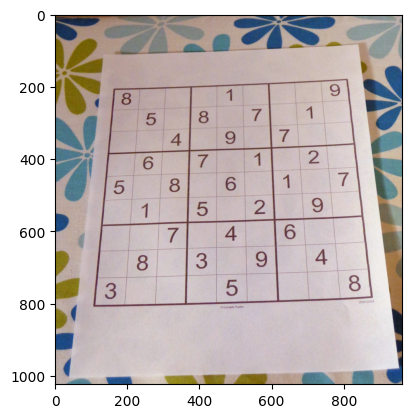

In [105]:
img = cv2.imread(r"images\img_0.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show_img(imgRGB)

### **Xử lý ảnh**

#### **Xây dựng hàm tiền xử lý ảnh**

Với các kỹ thuật:
- Đưa về ảnh xám
- Làm mờ ảnh
- Cắt ngưỡng

In [106]:
def pre_processing(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray, (15, 15), 1, 1)
    imgThresh = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)
    return imgThresh

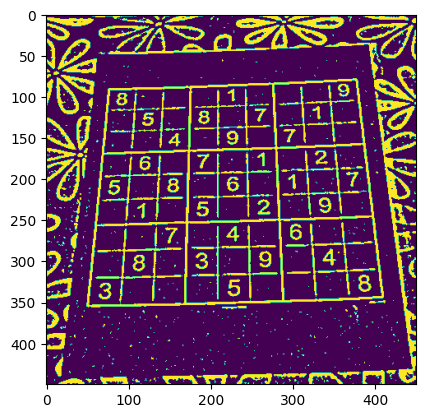

In [107]:
WIDTH = 450
HEIGHT = 450

img_resized = cv2.resize(img, (HEIGHT, WIDTH))
thresh = pre_processing(img_resized)

show_img([thresh])

#### **Tìm các đường viền (contours)**

Đường viền là một đường cong bao quanh một vùng được phân biệt theo màu sắc hoặc độ sáng khác nhau trên ảnh.
- `cv2.findContours`: Dùng để tìm đường viền, hàm trả về list các đường viền được tìm thấy trong ảnh đầu vào.
- `cv2.drawContours`: Được sử dụng để vẽ các đường viền đã được tìm thấy trên ảnh.

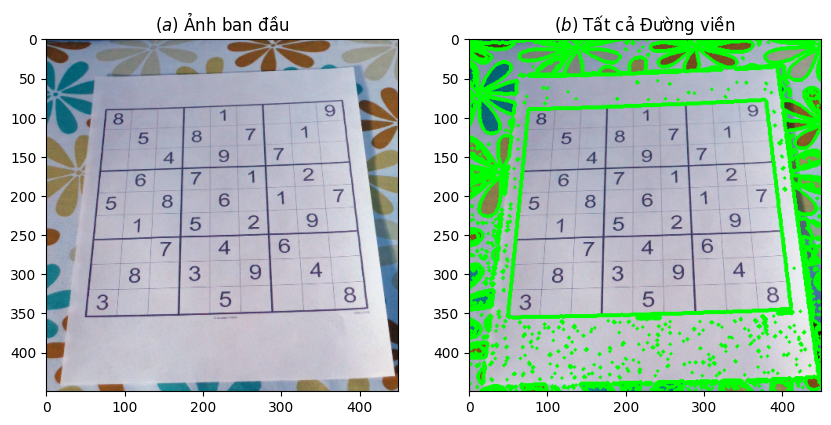

In [108]:
imgContours = img_resized.copy()
imgBigContours = img_resized.copy()
imgBigContours1 = img_resized.copy()
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3)

show_img([img_resized, imgContours], ["$(a)$ Ảnh ban đầu", "$(b)$ Tất cả Đường viền"], figsize=(10, 5))

#### **Tìm đường viền bao quanh câu đố sudoku**

Đường viền bao quanh sudoku sẽ là đường viền có diện tích lớn nhất. Do đó ta cần xác định được đường viền có kích thước lớn nhất. Đây là đoạn code Python để tìm và sắp xếp lại các điểm của đường viền có diện tích lớn nhất trong danh sách contours:
- Hàm `getBiggestContour(contours)` nhận vào danh sách các contours và trả về đường viền có diện tích lớn nhất trong danh sách đó cùng với diện tích của nó. 
- Hàm `reorder(myPoints)` nhận vào numpy array myPoints chứa 4 điểm của hình chữ nhật cần sắp xếp lại, và trả về một numpy array mới chứa các điểm đã được sắp xếp lại theo đúng thứ tự: điểm trái trên, điểm phải trên, điểm trái dưới và điểm phải dưới.

In [109]:
def get_biggest_contour(contours, image):
    biggest = np.array([[]])
    max_area = 0

    for i in contours:
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)

            if len(approx) == 4:
                if area > max_area:
                    max_area = area
                    biggest = approx
                else:
                    cv2.drawContours(image, [approx], -1, (255, 0, 0), 3)
            else:
                cv2.drawContours(image, [approx], -1, (255, 255, 0), 3)

    cv2.drawContours(image, [biggest], -1, (0, 255, 0), 3)

    return biggest, max_area

def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

- `cv2.getPerspectiveTransform(pts1, pts2)`: Hàm này tính toán ma trận biến đổi để áp dụng cho ảnh gốc và thu được ảnh đã biến đổi. Ma trận này được tính bằng cách sử dụng các điểm của 2 hình chữ nhật

$$H = \begin{bmatrix} a & b & c \\ d & e & f \\ g & h & 1 \end{bmatrix}$$

$$\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} a & b & c \\ d & e & f \\ g & h & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$
- Trong đó:
    - H là ma trận biến đổi.
    - $(x,y)$ và $(x',y')$ lần lượt là tọa độ của một điểm trên hình ảnh ban đầu và điểm tương ứng trên hình ảnh đã biến đổi.
    - $a,b,c,d,e,f,g,h$ là các tham số của ma trận biến đổi.

- `cv2.warpPerspective`: là một hàm trong thư viện OpenCV được sử dụng để thực hiện phép biến đổi hình học affine hoặc perspecive trên một ảnh.
$$dst(x',y') = \text{src}\left(\frac{H_{11} x' + H_{12} y' + H_{13}}{H_{31} x' + H_{32} y' + H_{33}}, \frac{H_{21} x' + H_{22} y' + H_{23}}{H_{31} x' + H_{32} y' + H_{33}}\right)$$

- Trong đó:
    - $\text{dst}$ là tọa độ điểm ảnh trên ảnh đích.
    - $\text{src}$ là tọa độ điểm ảnh trên ảnh gốc.

In [110]:
def get_perspective(img, masked_num, location, inv=False):
    pts1 = np.float32(location)
    pts2 = np.float32([[0, 0], [WIDTH, 0], [0, HEIGHT], [WIDTH, HEIGHT]])
    
    width, height = WIDTH, HEIGHT
    if inv:
        pts1, pts2 = pts2, pts1
        width, height = img.shape[1], img.shape[0]
    
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (width, height))
    return result

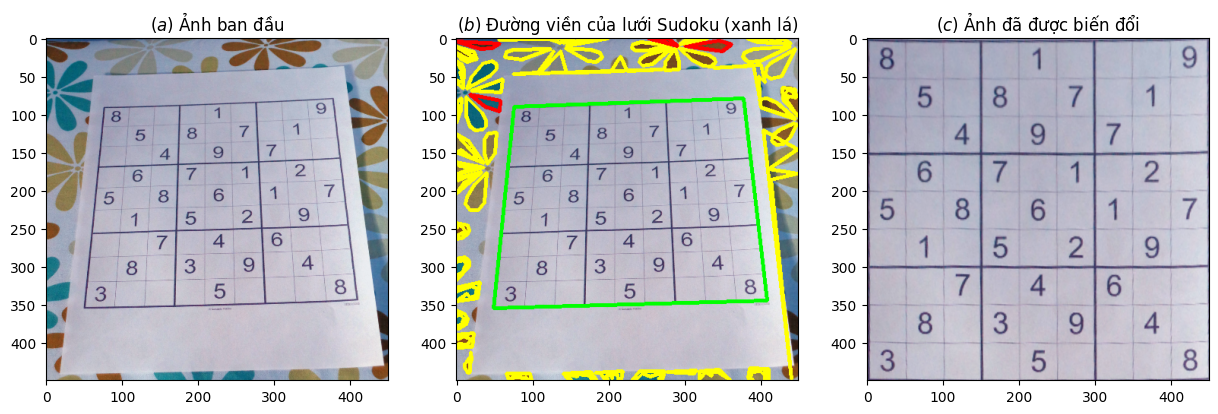

In [111]:
img_contours = img_resized.copy()
biggest, max_area = get_biggest_contour(contours, img_contours)

if biggest.size != 0:
    biggest = reorder(biggest)
    imgPerspective = get_perspective(img_resized, img_resized, biggest)
    imgWarpColored = cv2.cvtColor(imgPerspective, cv2.COLOR_BGR2RGB) 

show_img([img_resized, img_contours, cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2RGB)], ["$(a)$ Ảnh ban đầu", "$(b)$ Đường viền của lưới Sudoku (xanh lá)", "$(c)$ Ảnh đã được biến đổi"], figsize=(15, 5))

#### **Chia nhỏ lưới Sudoku**

In [112]:
def split_boxes(img):
    rows = np.vsplit(img, 9)
    boxes = []
    for row in rows:
        cols = np.hsplit(row, 9)
        for box in cols:
            boxes.append(box)
    return boxes  

In [113]:
boxes = np.array(split_boxes(imgWarpColored))

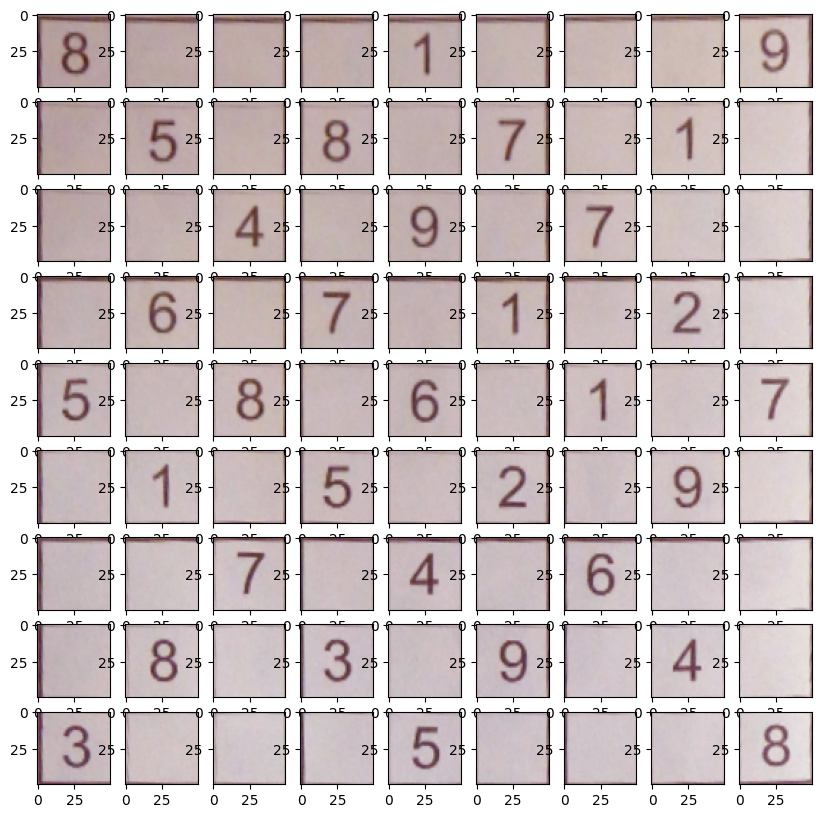

In [114]:
show_img(boxes, nrow=9, ncol=9, figsize=(10, 10))

### **Dự đoán các ô nhỏ**

Sử dụng model đã được huấn luyện đưa các ô đã được chia nhỏ vào

In [115]:
model = Resnet18(3, 10)
model.load_state_dict(torch.load("best_checkpoint.pth", map_location=torch.device("cpu")))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21912\2203111231.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_checkpoint.pth", map

<All keys matched successfully>

In [116]:
def transform(x):
    pil_img = Image.fromarray(np.uint8(x))

    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor()
    ])

    return transform(pil_img).numpy()

In [117]:
def get_predict(boxes, model):
    imgs = torch.Tensor(np.array(list(map(transform, boxes))))
    y_hat = model(imgs)
    y_hat = torch.softmax(y_hat, dim=1)
    value, indices = torch.max(y_hat, dim=1)
    getClass = np.where(value < 0.98, 0, indices)
    return getClass.reshape(9, 9)

pred = get_predict(boxes, model)

Tô màu trắng các ô được nhận diện là trống

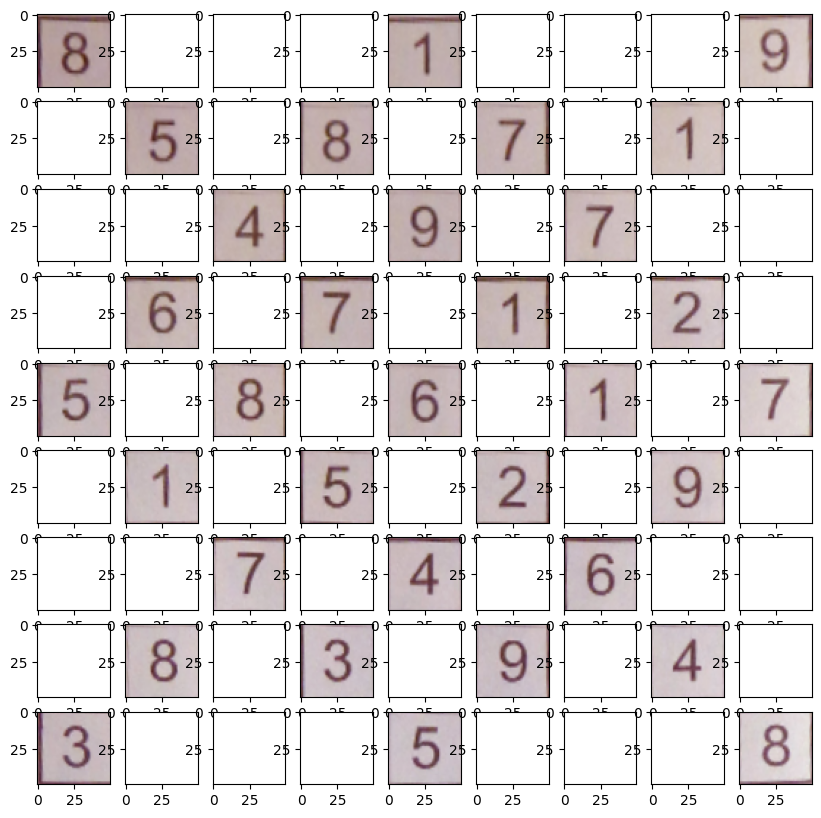

In [118]:
show_img(boxes, nrow=9, ncol=9, figsize=(10, 10), predictions=pred, boxes=boxes)

In [119]:
grid = pred.reshape(9, 9)
grid_copy = grid.copy()

In [120]:
def display_predict_number(img, img_, num_pred, biggest):
    img_empty = np.zeros(img_.shape)
    for i in range(9):
        for j in range(9):
            if num_pred[i, j] != 0:
                cv2.putText(img_empty, str(num_pred[i, j]), org=(j*50+10, i*50+35), fontScale=2, thickness=2,
                            fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL, color=(0, 255, 0))
    
    inv = get_perspective(img, img_empty, biggest, inv=True)
    combined = cv2.addWeighted(inv, 1, img, 0.5, 1, dtype=cv2.CV_8U)
    return np.clip(combined, 0, 255) 

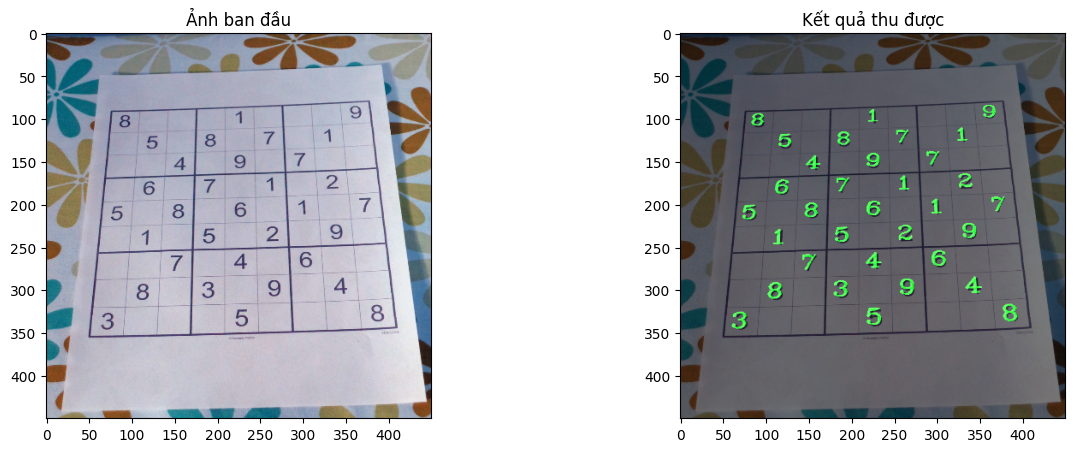

In [121]:
img_test = display_predict_number(img_resized, imgWarpColored, pred, biggest)
show_img([img_resized, img_test], title=["Ảnh ban đầu", "Kết quả thu được"], figsize=(15, 5))

### **Giải Sudoku**

Hàm `valid` nhận vào 3 tham số đầu vào là `grid`, một danh sách 2D biểu diễn một bảng Sudoku, `num`, số cần kiểm tra tính hợp lệ, và `pos`, một bộ giá trị đại diện cho vị trí (dòng, cột) mà số đang được đặt vào. Hàm trả về một giá trị boolean cho biết số `num` có thể được đặt vào vị trí `pos` trong `grid` mà không vi phạm luật chơi Sudoku hay không.

- Hàm kiểm tra tính hợp lệ của `num` theo ba cách sau:

1. Kiểm tra hàng: Hàm lặp qua từng phần tử trong hàng chứa vị trí `pos` và kiểm tra xem num đã có trong hàng đó chưa, trừ vị trí cột `pos[1]` hiện tại. Nếu num đã có trong cùng một hàng, hàm trả về False, cho biết số không hợp lệ ở vị trí đó.

2. Kiểm tra cột: Hàm lặp qua từng phần tử trong cột chứa vị trí `pos` và kiểm tra xem `num` đã có trong cột đó chưa, trừ vị trí dòng `pos[0]` hiện tại. Nếu num đã có trong cùng một cột, hàm trả về `False`, cho biết số không hợp lệ ở vị trí đó.

3. Kiểm tra ô vuông: Hàm xác định ô vuông (3x3 ô con) mà vị trí `pos` thuộc về, sau đó lặp qua từng phần tử trong ô vuông đó. Nó kiểm tra xem num đã có trong ô vuông đó chưa, trừ vị trí hiện tại `pos`. Nếu `num` đã có trong cùng một ô vuông, hàm trả về `False`, cho biết số không hợp lệ ở vị trí đó.

4. Nếu `num` vượt qua cả ba kiểm tra (nghĩa là không có trong cùng hàng, cột hoặc ô vuông), hàm trả về `True`, cho biết số hợp lệ ở vị trí đó theo luật chơi Sudoku.

In [122]:
def valid(grid, num, pos) -> bool:
    for i in range(len(grid[0])):
        if grid[pos[0]][i] == num and pos[1] != i:
            return False

    for i in range(len(grid)):
        if grid[i][pos[1]] == num and pos[0] != i:
            return False

    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if grid[i][j] == num and (i, j) != pos:
                return False

    return True

- Hàm `find_empty` nhận vào grid, một danh sách 2D biểu diễn một bảng Sudoku. Hàm lặp qua từng phần tử trong grid, tìm kiếm vị trí chưa được điền số (số 0) bằng cách so sánh giá trị của phần tử tại vị trí `grid[i][j]` với 0. 

- Nếu tìm thấy vị trí chưa được điền số, hàm trả về một bộ giá trị (dòng, cột) của vị trí đó bằng cách sử dụng `return (i, j)`. Nếu không tìm thấy vị trí chưa được điền số, hàm trả về `None`, cho biết không còn vị trí nào cần điền số trên bảng Sudoku.

In [123]:
def find_empty(grid) -> None:
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 0:
                return (i, j) 

    return None

- Hàm `solve` là một hàm đệ quy được sử dụng để giải quyết bài toán Sudoku. Hàm không nhận tham số đầu vào và trả về một giá trị boolean. Hàm sử dụng biến toàn cục `grid`, một danh sách 2D biểu diễn bảng Sudoku.

- Hàm bắt đầu bằng việc gọi hàm `find_empty(grid)` để tìm kiếm vị trí chưa được điền số trên bảng. Nếu không còn vị trí nào chưa điền số, tức là đã giải xong bảng Sudoku, hàm trả về `True`.

- Nếu vẫn còn vị trí chưa điền số, hàm lấy dòng và cột của vị trí đầu tiên tìm thấy bằng `row`, `col = find`.

- Tiếp theo, hàm lặp qua các số từ 1 đến 9, và kiểm tra tính hợp lệ của mỗi số bằng cách gọi hàm `valid(grid, i, (row, col))`. Nếu số đó hợp lệ, hàm gán giá trị đó vào vị trí `grid[row][col]`, và đệ quy gọi lại chính nó, tức là tiếp tục giải quyết bài toán với số vừa điền vào.

- Nếu không tìm thấy số nào hợp lệ để điền vào vị trí hiện tại, hàm đặt lại giá trị tại vị trí đó về 0 và trả về `False`, đồng nghĩa với việc không tìm thấy lời giải cho bài toán Sudoku. Quá trình đệ quy sẽ tiếp tục với các giá trị khác cho vị trí đang xét, cho đến khi hoàn thành việc giải quyết bài toán hoặc không tìm thấy lời giải.

In [124]:
def solve():
    global grid
    find = find_empty(grid)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1, 10):
        if valid(grid, i, (row, col)):
            grid[row][col] = i

            if solve():
                return True

            grid[row][col] = 0

    return False

In [125]:
solve()
print(grid)

[[8 7 2 4 1 3 5 6 9]
 [9 5 6 8 2 7 3 1 4]
 [1 3 4 6 9 5 7 8 2]
 [4 6 9 7 3 1 8 2 5]
 [5 2 8 9 6 4 1 3 7]
 [7 1 3 5 8 2 4 9 6]
 [2 9 7 1 4 8 6 5 3]
 [6 8 5 3 7 9 2 4 1]
 [3 4 1 2 5 6 9 7 8]]


#### **Hiển thị kết quả**

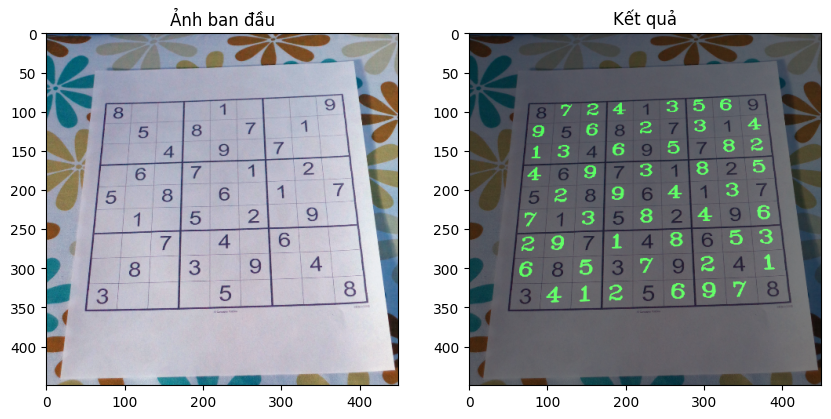

In [126]:
grid_show = np.where(grid == grid_copy, 0, grid) 
img_solved = display_predict_number(img_resized, imgWarpColored, grid_show, biggest)
show_img([img_resized, img_solved], title=["Ảnh ban đầu", "Kết quả"], figsize=(10, 5))